<a href="https://colab.research.google.com/github/philip-papasavvas/ml_sandbox/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing (NLP) Project using the SMS Spam dataset**

The following project will look at applying machine learning techniques, specifically for a natural language processing problem. The problem will focus on using SMS message data, curated from the UCI Machine Learning repository. The dataset contains almost 5,600 text messages in English, and are labelled with either ham (the text is not spam), or spam.

In this project we will explore concept such as: 
* **Lemmaisation**: this involves converting each word into its base form, for example by removing its ending. Converting the word running to run is an example of lemmaisation.
* **Bag of words**: This approach uses a collection of words to represent a sentence, taking account of the number of occurences of each word.

The data used in this project can be found here:
* https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

This workbook will have the following outline:
1. **Exploratory Data Analysis**
2. **Data pre-processing & feature engineering**
3. **Applying a model**
4. **Feature selection for NLP**
5. **Lemmaisation**

## 1. Exploratory Data Analysis
First, import the modules needed and load the data. Then, explore the statistics of the underlying data, such as the split between spam/non-spam (ham) messages and the length of the messages.

In [152]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set seaborn as default style even if we use matplotlib

# text preprocessing
import nltk

%matplotlib inline

In [153]:
# import the SMS text file
sms_messages = pd.read_csv(
    'https://raw.githubusercontent.com/philip-papasavvas/ml_sandbox/main/data/SMSSpamCollection.txt',
    sep='\t', names=['label', 'message'])

In [154]:
print(f"{len(sms_messages[sms_messages['label'] == 'ham'])} non-spam messages \n"
      f"{len(sms_messages[sms_messages['label'] != 'ham'])} spam messages")

4825 non-spam messages 
747 spam messages


We can see that there is an unbalanced dataset. This needs to be considered later on when applying machine learning models such as decision-tree algorithms, which generate a bias on unbalanced datasets. The issue here is when data is dominated by examples of only one type of class, then the classifer that is trainer will then be biased towards the majority class, in this case non-spam (ham) messages. So, when the classifier is applied to a test set that is also imbalanced, the classifier yields an optimistic accuracy estimate.

As an example, but also an extreme case, the classifier could assign every test case to the non-spam category, and therefore the accuracy would be equal to the proportion of overall messages that are not non-spam, in this case 87%, which might be judged as a good level of accuracy. 

This is a well known problem in binary classification and machine learning, and can be counterbalanced in a number of ways, see the topic of discussion [here](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data).

In [155]:
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Having inspected the dataset, it would be useful to add some more features to the data, such as the **length** of each message and the **number of words**. It's important that we understand the data well, to have the ability to add more features. This will enable us to carry out feature engineering more effectively. This is extremely important in the field of natural language processing (and spam classification), where feature engineering is one of the most important parts of the process.

In [156]:
sms_messages['length'] = sms_messages['message'].apply(len)
sms_messages['word_count'] = [len(x.split()) for x in sms_messages["message"]]

In [157]:
sms_messages.groupby('label').describe()

length                                                           \
        count        mean        std   min    25%    50%    75%    max   
label                                                                    
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0   
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0  
spam       747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0

Add in a histogram for the length, and word count, split by spam and non-spam.

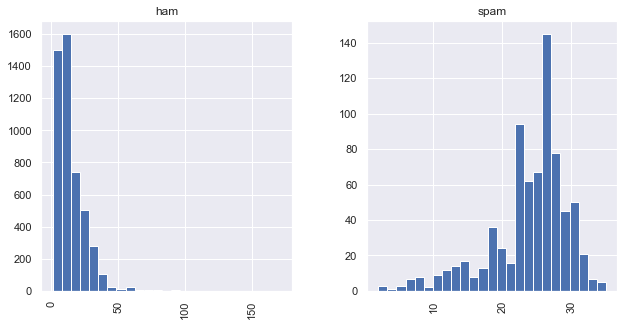

In [158]:
hist_plt = sms_messages.hist(column='word_count', by='label', figsize=(10,5), bins=25)


### Inspecting the word_count and length of the messages

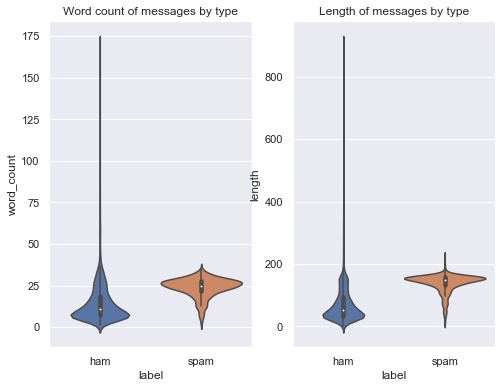

In [159]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(121)
ax1.set_title("Word count of messages by type")
g = sns.catplot(data=sms_messages, y='word_count', x='label',
           kind='violin', split=True, ax=ax1)

ax2 = fig.add_subplot(122)
ax2.set_title("Length of messages by type")
g = sns.catplot(data=sms_messages, x='label', y='length',
                kind='violin', split=True, ax=ax2)

plt.close(2)
plt.close(3)

Therefore, from the above, for:
- word_count: non-spam messages have many fewer words than the spam messages. On average the non-spam messages contain around 10 words, with the spam messaged containing around 25 words. The dispersion between the non-spam messages is much larger than the spam messages, with an outlier of almost 200 words in a message!
- length: spam messages tend to be much longer, whilst the ham messages are much shorter. Again, the dispersion of the data for the non-spam is much greater than the spam messages.

We can also confirm the above intuitions using the *describe* method. Let's demonstrate this for the non-spam messages

In [160]:
print("Non-spam messages, length statistics \n")
sms_messages[sms_messages['label'] == 'ham'].describe().T

Non-spam messages, length statistics 



,count,mean,std,min,25%,50%,75%,max
length,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
word_count,4825.0,14.310259,11.517945,1.0,7.0,11.0,19.0,171.0


Add in the TRUE/FALSE indicator for whether a message is spam or not, rather than using the string label. It's cleaner from a mathematical standpoint.

In [220]:
sms_messages['is_spam'] = np.where(sms_messages['label'] == 'spam', 1, 0)

## 2. Data pre-processing & feature engineering


Just by looking at the data, we can try to extract some features from the messages, to further enrich the amount of data we have in order to best classify whether a message is spam or not.
To do this, let's look at some examples of the spam and ham messages.

In [221]:
spam_messages = sms_messages.loc[sms_messages['is_spam']==1, 'message'] # pd.Series
non_spam_messages = sms_messages.loc[sms_messages['is_spam']==0, 'message'] # pd.Series

np.random.seed(1)

print("Spam message examples: \n", "*" * 30, "\n \n")
for random_choice in np.random.randint(0, len(spam_messages), 5):
    print(f"{spam_messages.iloc[random_choice]} \n \n")

    
print("Non-spam message examples: \n", "*"*30, "\n \n")
for random_choice in np.random.randint(0, len(non_spam_messages), 5):
    print(f"{non_spam_messages.iloc[random_choice]} \n \n")

Spam message examples: 
 ****************************** 
 

Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16 
 

RGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50 
 

You are guaranteed the latest Nokia Phone, a 40GB iPod MP3 player or a £500 prize! Txt word: COLLECT to No: 83355! IBHltd LdnW15H 150p/Mtmsgrcvd18+ 
 

XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription  
 

Santa calling! Would your little ones like a call from Santa Xmas Eve? Call 09077818151 to book you time. Calls1.50ppm last 3mins 30s T&C www.santacalling.com 
 

Non-spam message examples: 
 ****************************** 
 

Like I made him throw up when we were smoking in our friend's car one time, it was awesome 
 



Having investigated some examples of spam and non-spam messages above, we see that spam messages have:
- **more** capital letters
- **more** punctuation: question marks and exclamation marks
- **more** numbers: prompting the user that they have won a specific amount, or prompting them to call/message a specific number
We can assess these intuitions later when running classifiers for the messages.

It doesn't seem like punctuation in messages (commas, full stops) gives us lots of insight about whether a message is spam or not, so we will remove these bits of punctuation from the messages. Note that we still extract a feature detailing the number of question/exclamation marks in the text.

In addition to this, common words (the, a, there, etc.) appearing in the English language (stopwords) do not give much away regarding if the messages are spam or not. I will write functions to:
* remove punctuation
* remove stopwords - we wil make use of the **corupus** package within the **nltk** package to do so.

Whilst also adding the feature for the number of digits contained in the text body, and the level of punctuation (question marks/exclamation marks).

In [206]:
import re

# functions below will substitute any non-numeric character with empty space, and count the number
# numeric characters remaining
def count_numerics(input_str: str) -> int:
    return len(re.sub("[^0-9]", "", input_str))

def count_exclamation_question(input_str: str) -> int:
    return len(re.sub("[^!?]", "", input_str))

sms_messages['numeric_count'] = sms_messages['message'].apply(count_numerics)
sms_messages['exclamation_question_count'] = sms_messages['message'].apply(count_exclamation_question)

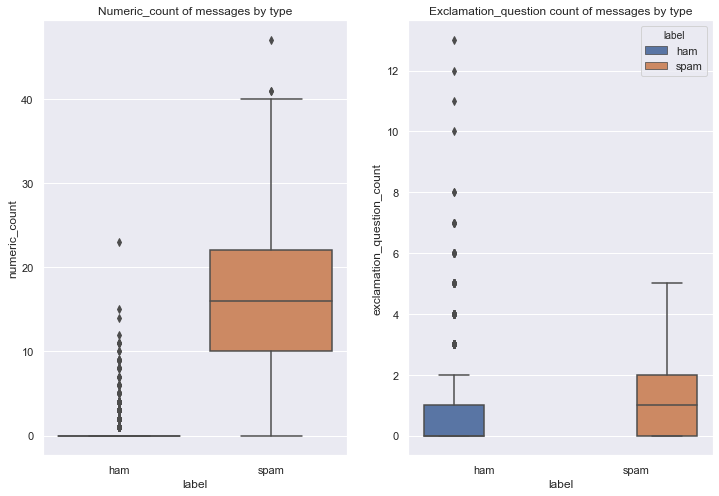

In [213]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
ax1.set_title("Numeric_count of messages by type")
g = sns.boxplot(data=sms_messages, x='label', y='numeric_count', ax=ax1)

ax2 = fig.add_subplot(122)
ax2.set_title("Exclamation_question count of messages by type")
g = sns.boxplot(data=sms_messages, x='label', y='exclamation_question_count', hue='label', ax=ax2)

plt.close(2)
plt.close(3)

it looks like in general, spam messgaes have more numbers in each message than non-spam messages, and more exclamation/question marks in them too.

## 3. Application of common ML models
After adding features to the data, with regard to the number of numeric characters in each message, the length of the message, and the count of any exclamation and punctuation marks, we can attempt to feed in this data into a machine learning model to classify messages if they are spam or not. It might be unusual to do this in an NLP problem, but let's try it anyway and investigate the results we get, before diving into more detailed NLP techniques.

As mentioned above we have an unbalanced dataset, where 13% of the messages in the dataset are spam, and the rest are not. In order to counterbalance this, we will use the two solutions:
 - **undersample** the majority spam class, or **oversample** the minority non-spam class, to prevent the bias in the first place
 - modify the **cost of misclassification** to prevent bias.

I'd like to highlight the dangers of not balancing the dataset to address the imbalance between the spam/non-spam messages. Therefore I will use a logistic regression classifier without using stratification of the sample (will not adjust the sampling of the data to ensure the split datasets have the same proportion of spam/non-spam messages). 

Before training the machine learning model it is crucial that we separate out the dataset into three different parts:
- **training set**: this input data is used for the model to learn about the dataset, and fit its parameters.
- **validation set**: this data is used to evlatue a given model in order to tune the model parameters. The model will *see* the data, but won't learn from it. Strictly speaking this dataset does influence the model, but indirectly.
- **testing set**: this is the gold standard to evaluate the fit of the model. The test set is used once a model is completely trained, and will give you the accuracy of the model.


In [231]:
sms_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   label                       5572 non-null   object
 1   message                     5572 non-null   object
 2   length                      5572 non-null   int64 
 3   word_count                  5572 non-null   int64 
 4   is_spam                     5572 non-null   int64 
 5   numeric_count               5572 non-null   int64 
 6   exclamation_question_count  5572 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 304.8+ KB


In [232]:
from sklearn.model_selection import train_test_split
X = sms_messages[['length', 'word_count', 
                  'numeric_count', 'exclamation_question_count']]
y = sms_messages['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% of the data will be used to test the model accuracy
                                                   random_state=1,
                                                   stratify=y)

# further split the train set into 
# choose the validation set to be 25% of the training set we've just taken, overall we
# have 20% of the original data as the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25,
                                                 random_state=1,
                                                 stratify = y_train)

### 3.1 Logistic regression
Firstly we will apply logistic regression to the data, using the training set to train the model, and then the test set to evaluate the performance of the model.
We can then verify the performance of the model using the validation set.

In [247]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train)

test_set_predictions = logistic.predict(X_test)
test_set_accuracy_score = accuracy_score(y_true=y_test, y_pred=test_set_predictions)
print(f"Accuracy score for the test set was {100*test_set_accuracy_score:.2f}% \n ")


val_set_predictions = logistic.predict(X_val)
validation_set_accuracy = accuracy_score(y_true=y_val, y_pred=val_set_predictions)
print(f"Accuracy score for the validation set was {100*validation_set_accuracy:.2f}%")

Accuracy score for the test set was 96.59% 
 
Accuracy score for the validation set was 97.22%


In [250]:
confusion_test = confusion_matrix(y_true=y_test, y_pred=test_set_predictions)
confusion_validation = confusion_matrix(y_true=y_val, y_pred=val_set_predictions)

It would be useful to write a function to plot a confusion matrix for the results of the two tests.

In [293]:
def plot_confusion_matrix(input_matrix: np.ndarray, labels=None):
    """Seaborn plot of the confusion matrix, given labels (if so)"""
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
        
    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(data=input_matrix, xticklabels=labels, yticklabels=labels, ax=ax,
               cmap='YlGnBu', annot=True, fmt='g')
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    plt.close()
        
    return fig      

<Figure size 576x576 with 0 Axes>

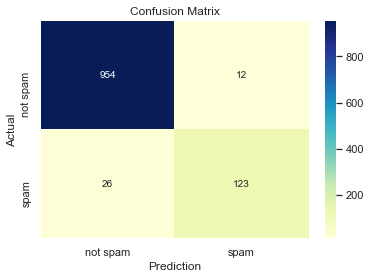

In [294]:
plot_confusion_matrix(confusion_test, labels=['not spam', 'spam'])

<Figure size 576x576 with 0 Axes>

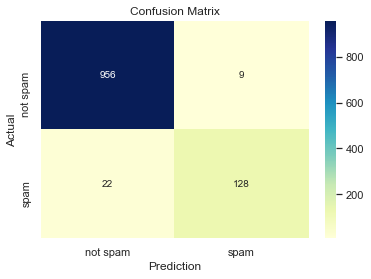

In [296]:
plot_confusion_matrix(confusion_validation, labels=['not spam', 'spam'])

## 4. Feature selection for NLP
There are many different ways to look at the features of the text message data:
* **tokenisation**: we have converted the original text strings into lists of tokens (meaningful words that are free of stopwords and punctuation)
* **stemming**: this is the process of reducing a word to its word stem/root form. This is where you would remove affixes to a word, such as  An example of this are ed, -ize, -s, etc. Stems are created when the suffixes/prefixes are removed from the word. Converting our list of words into stems will then give us a vector that we can use with machine learning libraries such as **scikit-learn**.

In [252]:
from nltk.corpus import stopwords # common words

english_stopwords = stopwords.words('english')
len(english_stopwords)

179

We can see that overall there are 179 stopwords! These can be removed from the dataset to reduce each message and will ensure smaller feature vectors for use in our machine learning model. Now let's construct a function to remove punctuation from a text, as well as removing the stopwords, and test the function afterwards.

In [253]:
def clean_text(txt: str) -> list:
  """Method to clean input text (list)"""
  # remove punctuation from the list
  no_punc = [char for char in txt if char not in string.punctuation]
  
  # join the chaaracters with no punctuation to get the original words
  no_punc = "".join(no_punc)

  # remove stopwords
  return [word for word in no_punc.split() if word not in english_stopwords]

clean_text(sms_messages['message'][10])

['Im',
 'gonna',
 'home',
 'soon',
 'dont',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'Ive',
 'cried',
 'enough',
 'today']

We saw earlier the original text has been reduced in size from a string, to a list of strings (words).

We will go ahead and apply this **clean_text** function to all of our messages.

In [254]:
sms_messages['cleaned_message'] = sms_messages['message'].apply(clean_text)

## Lemmaisation